In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

The data for this project comes from Kaggle. There are four separate datasets but we are only going to read in the Train_transaction set for now. Let's begin. 

# EDA

In [2]:
#load dataframe
df_tr = pd.read_csv('/Users/kaoliver/Downloads/ieee-fraud-detection/train_transaction.csv')

In [3]:
#check top of frame
df_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The target variable appears to be the IsFraud column.  

In [4]:
#check info
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [5]:
#check shape
df_tr.shape

(590540, 394)

In [6]:
#check columns
list(df_tr.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

Here is a breakdown of what the columns represent, taken from from the Kaggle Competition discussion board. 

TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”

TransactionAMT: transaction payment amount in USD
“Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”

ProductCD: product code, the product for each transaction
“Product isn't necessary to be a real 'product' (like one item to be added to the shopping cart). It could be any kind of service.”

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

addr: address
“both addresses are for purchaser
addr1 as billing region
addr2 as billing country”

dist: distance
"distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”

P_ and (R__) emaildomain: purchaser and recipient email domain
“ certain transactions don't need recipient, so R_emaildomain is null.”

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. for both purchaser and recipient. 

D1-D15: timedelta, such as days between previous transaction, etc.

M1-M9: match, such as names on card and address, etc.

Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

In [7]:
#check the sum of null values by feature
df_tr.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64

Whats going on with the Vesta features. Seems like there are a massive amount of Null values. 

In [8]:
#check the sum of null values 
df_tr['V200'].isnull().sum()


450721

In [9]:
#check the sum of null values 
df_tr['V100'].isnull().sum()

314

In [10]:
#check the sum of null values 
df_tr['V150'].isnull().sum()

508589

In [11]:
#check the sum of null values 
df_tr['V99'].isnull().sum()

314

In [12]:
#check the sum of null values 
df_tr['V101'].isnull().sum()

314

In [13]:
#check the sum of null values 
df_tr['V1'].isnull().sum()

279287

Yuck, so many null values. Let's get rid of them and maybe bring them back at a later date.

In [14]:
#delete Vesta features 
df_tr_2 = df_tr.drop(df_tr.loc[:, 'V1':'V339'].columns, axis = 1)

In [15]:
df_tr_2.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,T,T,T,M2,F,T,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,315.0,T,T,T,M0,F,F,F,F,F
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#check shape of new dataframe 
df_tr_2.shape

(590540, 55)

In [17]:
#check info
df_tr_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int64  
 1   isFraud         590540 non-null  int64  
 2   TransactionDT   590540 non-null  int64  
 3   TransactionAmt  590540 non-null  float64
 4   ProductCD       590540 non-null  object 
 5   card1           590540 non-null  int64  
 6   card2           581607 non-null  float64
 7   card3           588975 non-null  float64
 8   card4           588963 non-null  object 
 9   card5           586281 non-null  float64
 10  card6           588969 non-null  object 
 11  addr1           524834 non-null  float64
 12  addr2           524834 non-null  float64
 13  dist1           238269 non-null  float64
 14  dist2           37627 non-null   float64
 15  P_emaildomain   496084 non-null  object 
 16  R_emaildomain   137291 non-null  object 
 17  C1        

Now, according to Vesta, the categorical features are :  

productCD, 
card1 - card6
addr1, addr2
P_emaildomain
R_emaildomain
M1 - M9.

Let's get rid of those, and try to have a nice and clean purely numerical dataset for our First Simple Model.  

In [18]:
#create new dataframe of only numeric values

df_tr_3 = df_tr_2.drop(columns = ['TransactionID', 'ProductCD', 'card1', 'card2', 'card3', 
                                  'card4', 'card5','card6', 'addr1', 'addr2', 
                                  'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
                                    'M4', 'M5', 'M6', 'M7', 'M8', 'M9'])

In [19]:
#check five rows from the dataframe
df_tr_3.sample(5)

,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
244891,0,5834484,383.110,NaN,NaN,1.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
449805,0,11472724,39.000,6.0,NaN,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,7.0,7.0,NaN,NaN,NaN,613.0
199189,0,4502073,30.899,NaN,NaN,1.0,1.0,0.0,1.0,0.0,...,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0
112051,0,2178008,100.000,NaN,NaN,1.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
559739,0,14832870,110.000,NaN,NaN,5.0,3.0,0.0,3.0,0.0,...,256.0,0.0,26.666666,0.666666,253.0,NaN,NaN,26.0,NaN,NaN


In [20]:
#check top five rows 
df_tr_3.head()

,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,0,86400,68.5,19.0,NaN,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0,86401,29.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0,86469,59.0,287.0,NaN,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,0,86499,50.0,NaN,NaN,2.0,5.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0,86506,50.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
#check info
df_tr_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 34 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   isFraud         590540 non-null  int64  
 1   TransactionDT   590540 non-null  int64  
 2   TransactionAmt  590540 non-null  float64
 3   dist1           238269 non-null  float64
 4   dist2           37627 non-null   float64
 5   C1              590540 non-null  float64
 6   C2              590540 non-null  float64
 7   C3              590540 non-null  float64
 8   C4              590540 non-null  float64
 9   C5              590540 non-null  float64
 10  C6              590540 non-null  float64
 11  C7              590540 non-null  float64
 12  C8              590540 non-null  float64
 13  C9              590540 non-null  float64
 14  C10             590540 non-null  float64
 15  C11             590540 non-null  float64
 16  C12             590540 non-null  float64
 17  C13       

Next, lets deal with the Null values.

In [22]:
#check for null values 
df_tr_3.isnull().sum()

isFraud                0
TransactionDT          0
TransactionAmt         0
dist1             352271
dist2             552913
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022
D11               279287
D12               525823
D13               528588
D14               528353
D15                89113
dtype: int64

Our Null values range from none in some columns, to more than 500,000 in some others. I don't want 
to remove any more columns, but I also may not have a very indicative model if I drop this many rows. So Let's fill them instead using the interpolate method, and pad the NA's with data already in the dataset.    

In [23]:
#create new dataframe with values for NaNs
df_tr_4 = df_tr_3.interpolate(axis=0, method='pad')

In [24]:
#check sample of new dataframe
df_tr_4.sample(10)

,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
326882,0,8040817,427.500,2.0,1384.0,3.0,2.0,0.0,0.0,0.0,...,22.0,22.0,0.041666,0.041666,9.0,0.0,22.0,0.0,0.0,9.0
500025,0,13111985,107.950,2.0,19.0,143.0,146.0,0.0,0.0,101.0,...,0.0,0.0,0.750000,0.750000,232.0,41.0,0.0,0.0,0.0,49.0
223856,1,5272148,251.950,18.0,5.0,2.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
79407,0,1719081,311.950,0.0,88.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,27.875000,0.875000,0.0,0.0,0.0,0.0,0.0,0.0
229703,0,5439750,39.000,2.0,924.0,7.0,6.0,0.0,0.0,4.0,...,0.0,0.0,149.958328,0.958333,478.0,0.0,0.0,0.0,0.0,491.0
101856,0,2051344,100.000,1.0,1615.0,1200.0,1311.0,0.0,879.0,0.0,...,0.0,602.0,72.708336,0.708333,8.0,0.0,0.0,0.0,0.0,8.0
399779,0,10088069,77.000,4.0,1277.0,1.0,1.0,0.0,0.0,0.0,...,0.0,11.0,402.750000,0.750000,0.0,0.0,0.0,0.0,193.0,574.0
63527,0,1446577,150.000,11.0,30.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,880.708313,0.708333,220.0,0.0,1.0,0.0,1.0,220.0
199711,0,4548632,92.000,6.0,247.0,3.0,6.0,0.0,0.0,0.0,...,44.0,44.0,25.625000,0.625000,303.0,61.0,44.0,0.0,17.0,361.0
93152,0,1921488,64.713,2.0,13.0,1.0,5.0,0.0,1.0,0.0,...,5.0,0.0,6.208333,0.208333,0.0,49.0,5.0,5.0,33.0,5.0


In [25]:
#check null values
df_tr_4.isnull().sum()

isFraud            0
TransactionDT      0
TransactionAmt     0
dist1              0
dist2             11
C1                 0
C2                 0
C3                 0
C4                 0
C5                 0
C6                 0
C7                 0
C8                 0
C9                 0
C10                0
C11                0
C12                0
C13                0
C14                0
D1                 0
D2                 3
D3                 0
D4                 1
D5                 3
D6                10
D7                10
D8                10
D9                10
D10                0
D11                0
D12               10
D13               10
D14               10
D15                0
dtype: int64

In [26]:
#drop remaining NaN values
df_tr_4=df_tr_4.dropna(axis=0)

In [27]:
df_tr_4.sample(10)

,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
168984,0,3623880,19.50,27.0,2142.0,1.0,1.0,0.0,0.0,0.0,...,410.0,30.0,315.916656,0.916666,0.0,141.0,410.0,0.0,0.0,0.0
580717,0,15485998,44.50,717.0,76.0,2.0,2.0,0.0,0.0,0.0,...,0.0,3.0,61.208332,0.208333,0.0,0.0,0.0,0.0,0.0,344.0
109206,0,2148985,100.00,312.0,10.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,106.833336,0.833333,0.0,12.0,1.0,1.0,2.0,1.0
341384,0,8400576,117.00,991.0,7.0,12.0,11.0,0.0,0.0,1.0,...,0.0,0.0,644.208313,0.208333,265.0,141.0,0.0,0.0,0.0,265.0
422313,0,10695223,72.00,3.0,7.0,3.0,5.0,0.0,0.0,1.0,...,3.0,3.0,0.750000,0.750000,115.0,115.0,3.0,0.0,0.0,115.0
300958,0,7428427,92.00,1301.0,7.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.958333,0.958333,6.0,6.0,0.0,0.0,7.0,540.0
134156,0,2675432,30.95,4.0,284.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.958333,0.958333,384.0,0.0,0.0,0.0,0.0,511.0
465307,0,11982920,49.00,4.0,687.0,3.0,2.0,0.0,0.0,0.0,...,57.0,57.0,1259.666626,0.666666,157.0,157.0,57.0,5.0,5.0,157.0
541142,0,14261123,107.95,19.0,68.0,4.0,5.0,0.0,0.0,4.0,...,0.0,2.0,2.041666,0.041666,16.0,406.0,0.0,0.0,0.0,406.0
583695,0,15611238,146.00,1.0,1.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,99.666664,0.666666,70.0,70.0,0.0,0.0,0.0,70.0


There we go, a null-free data set. Before we model let's investigate our class imbalance. 

<AxesSubplot:ylabel='isFraud'>

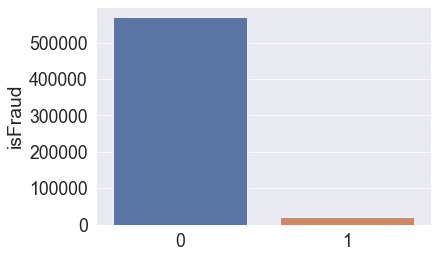

In [28]:
#plot class imbalance 

sns.set(style='darkgrid', rc={"grid.linewidth": 3.5})
sns.set_context("paper", font_scale=2.0)  
sns.barplot(x=df_tr_4['isFraud'].value_counts().index, 
            y=df_tr_4['isFraud'].value_counts())

As expected, far more 0 values, or not fraud, than 1 values (fraud) Clearly going to need to 
deal with this, but lets start modeling. I'm going to begin with a dummy classifier, set the strategy to stratified, given the class imbalance, and move from there. Since I'm worried about false positives and false negatives I'll focus on the f1 scores

In [29]:
#set target variable and initiate a train-test split

X = df_tr_4.drop(columns='isFraud', axis=1)
y = df_tr_4['isFraud']



X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [30]:
#instantiate and run dummy model 
dummy_model = DummyClassifier(strategy="stratified")
dummy_model.fit(X_train, y_train)
y_hat_dummy = dummy_model.predict(X_test)

In [31]:
#print model metrics  

print(dummy_model.score(X_test, y_test))
print(confusion_matrix(y_test, y_hat_dummy))
print(classification_report(y_test, y_hat_dummy))


0.9324608996633544
[[137480   4922]
 [  5033    198]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    142402
           1       0.04      0.04      0.04      5231

    accuracy                           0.93    147633
   macro avg       0.50      0.50      0.50    147633
weighted avg       0.93      0.93      0.93    147633



In [32]:
print(cross_val_score(dummy_model, X_train, y_train, cv=3))
print(np.mean(cross_val_score(dummy_model, X_train, y_train, cv=3)))

[0.9330362  0.93330037 0.93357809]
0.9326117192297967


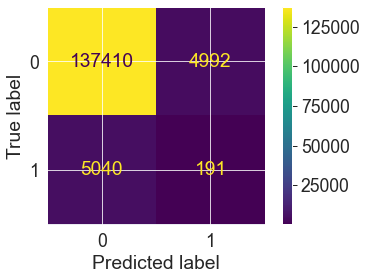

In [33]:
#create dummy model confusion matrix

plot_confusion_matrix(dummy_model, X_test, y_test)

And we have an FSM! Obviously there is so much data missing, but an FSM none the less.

In [34]:
df_tr_4.head()

,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
11,0,86555,16.495,19.0,30.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,83.0,0.0,0.0,302.0,0.0,0.0,0.0,0.0
12,0,86564,50.000,19.0,30.0,4.0,2.0,0.0,0.0,0.0,...,0.0,0.0,83.0,0.0,107.0,302.0,0.0,0.0,0.0,107.0
13,0,86585,40.000,19.0,30.0,6.0,5.0,0.0,0.0,2.0,...,0.0,0.0,83.0,0.0,45.0,302.0,0.0,0.0,0.0,45.0
14,0,86596,10.500,19.0,30.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,83.0,0.0,0.0,302.0,0.0,0.0,0.0,0.0
15,0,86618,57.950,3.0,30.0,4.0,4.0,0.0,0.0,1.0,...,0.0,0.0,83.0,0.0,465.0,423.0,0.0,0.0,0.0,0.0


It's pretty obvious that the TransactionDT and TransactionAmt columns need to be scaled down. 
Let's do that and keep it moving. 

In [35]:
#Create another train test split, create validation set and repeat

X = df_tr_4.drop(columns='isFraud', axis=1)
y = df_tr_4['isFraud']



X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#initiate scaler

ss = StandardScaler()

X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=42)




In [36]:
#scale data on these two columns

X_t[['TransactionDT', 'TransactionAmt', ]]= ss.fit_transform(X_t[['TransactionDT', 'TransactionAmt']])



/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [37]:
X_t.head()

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
540166,1.484742,-0.332047,2.0,7.0,2.0,1.0,0.0,0.0,0.0,1.0,...,249.0,0.0,19.833332,0.833333,5.0,2.0,0.0,19.0,249.0,5.0
548831,1.539572,0.265223,2.0,2527.0,1.0,1.0,0.0,1.0,0.0,1.0,...,2.0,0.0,0.750000,0.750000,0.0,0.0,2.0,0.0,0.0,0.0
438510,0.808248,-0.315888,90.0,2366.0,2.0,2.0,0.0,0.0,1.0,2.0,...,116.0,3.0,86.625000,0.625000,0.0,473.0,116.0,116.0,80.0,473.0
389402,0.515129,-0.274979,18.0,6.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,39.958332,0.958333,0.0,0.0,559.0,0.0,0.0,0.0
570833,1.684398,0.146588,2.0,344.0,2.0,4.0,0.0,0.0,0.0,1.0,...,134.0,1.0,974.500000,0.500000,141.0,410.0,0.0,820.0,59.0,410.0


Alright, lets build another dummy model.

In [38]:
#fit on training data
dummy_model.fit(X_t, y_t)

#predict on validation set
y_hat_dummy = dummy_model.predict(X_val)

In [39]:
print(dummy_model.score(X_val, y_val))
print(confusion_matrix(y_val, y_hat_dummy))
print(classification_report(y_val, y_hat_dummy))

0.9327697698782559
[[103101   3779]
 [  3716    128]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96    106880
           1       0.03      0.03      0.03      3844

    accuracy                           0.93    110724
   macro avg       0.50      0.50      0.50    110724
weighted avg       0.93      0.93      0.93    110724



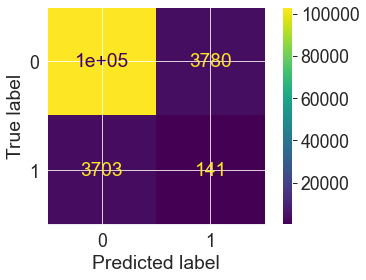

In [40]:
plot_confusion_matrix(dummy_model, X_val, y_val)

The model improved, albeit very slightly.Butafter a couple iterations of the dummy classifier, we have a solid baseline to go from. Now lets create another train test split, and create the datasets for modeling. 
First  we're going to create a numeric only dataset like the one above, and begin preprocessing. 

# PREPROCESSING

In [41]:
#bring back dataframe  
df_tr_2.sample(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
92034,3079034,0,1903623,41.510,C,9500,321.0,150.0,visa,226.0,...,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
12188,2999188,0,347191,42.596,C,3154,408.0,185.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
43120,3030120,0,1035091,39.000,W,16163,551.0,150.0,visa,226.0,...,493.0,NaN,NaN,NaN,M0,T,NaN,NaN,NaN,NaN
151447,3138447,0,3114654,57.950,W,2884,490.0,150.0,visa,226.0,...,426.0,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN
509045,3496045,0,13333194,59.000,W,10112,360.0,150.0,visa,166.0,...,96.0,NaN,NaN,NaN,M0,F,T,NaN,NaN,NaN


Null values are but we can take care of those. 

In [42]:
#create new dataframe

df_tr_5 = df_tr_2.interpolate(axis=0, method='pad')

In [43]:
#
df_tr_5.sample(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
296302,3283302,1,7324847,100.000,H,15497,490.0,150.0,visa,226.0,...,0.0,T,F,F,M2,F,F,F,F,T
292636,3279636,0,7229995,60.481,C,16062,500.0,185.0,mastercard,137.0,...,18.0,T,T,T,M2,F,T,F,T,T
245396,3232396,0,5847153,47.950,W,13045,122.0,150.0,mastercard,166.0,...,0.0,T,T,T,M0,T,F,F,T,T
399401,3386401,0,10081812,107.000,W,12544,321.0,150.0,visa,226.0,...,143.0,T,T,T,M0,T,F,F,T,T
188249,3175249,0,4210877,82.950,W,5938,111.0,150.0,visa,162.0,...,188.0,T,T,T,M0,F,F,F,F,T


The TransactionID column needs to be removed, and will not be in either dataset.

In [44]:
df_tr_5 = df_tr_5.drop(columns='TransactionID')

In [45]:
df_tr_5.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,0.0,T,T,T,M2,F,T,NaN,NaN,NaN
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.0,T,T,T,M0,T,T,NaN,NaN,NaN
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,315.0,T,T,T,M0,F,F,F,F,F
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,111.0,T,T,T,M0,T,F,F,F,F
4,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,111.0,T,T,T,M0,T,F,F,F,F


<AxesSubplot:xlabel='ProductCD'>

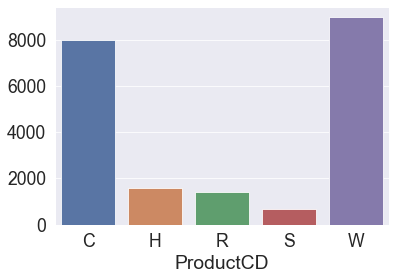

In [46]:
fr_by_pr = df_tr_5.groupby('ProductCD').sum().isFraud

sns.set(style='darkgrid', rc={"grid.linewidth": 3.5})
sns.set_context("paper", font_scale=2.0)  
sns.barplot(x=fr_by_pr.index, 
            y=fr_by_pr.values)




In [47]:
df_tr_5.isnull().sum()

isFraud            0
TransactionDT      0
TransactionAmt     0
ProductCD          0
card1              0
card2              1
card3              0
card4              0
card5              0
card6              0
addr1              0
addr2              0
dist1              0
dist2             11
P_emaildomain      1
R_emaildomain     10
C1                 0
C2                 0
C3                 0
C4                 0
C5                 0
C6                 0
C7                 0
C8                 0
C9                 0
C10                0
C11                0
C12                0
C13                0
C14                0
D1                 0
D2                 3
D3                 0
D4                 1
D5                 3
D6                10
D7                10
D8                10
D9                10
D10                0
D11                0
D12               10
D13               10
D14               10
D15                0
M1                 0
M2                 0
M3           

In [48]:
df_tr_5 = df_tr_5.dropna(axis=0)

In [49]:
df_tr_5.isnull().sum()

isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
dist1             0
dist2             0
P_emaildomain     0
R_emaildomain     0
C1                0
C2                0
C3                0
C4                0
C5                0
C6                0
C7                0
C8                0
C9                0
C10               0
C11               0
C12               0
C13               0
C14               0
D1                0
D2                0
D3                0
D4                0
D5                0
D6                0
D7                0
D8                0
D9                0
D10               0
D11               0
D12               0
D13               0
D14               0
D15               0
M1                0
M2                0
M3                0
M4                0
M5                0


In [50]:
X = df_tr_5.drop(columns='isFraud', axis=1)
y = df_tr_5['isFraud']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [51]:
X_train.shape



(442896, 53)

In [52]:
y_train.shape

(442896,)

In [53]:
X_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
4570,166961,844.95,W,2795,174.0,150.0,visa,141.0,credit,269.0,...,118.0,T,F,F,M0,F,F,F,F,T
77328,1699272,250.00,R,15063,514.0,150.0,visa,226.0,credit,269.0,...,81.0,T,F,F,M2,F,T,F,T,T
449149,11459346,48.95,W,13597,198.0,150.0,visa,226.0,debit,191.0,...,611.0,T,T,T,M1,T,T,T,T,T
333089,8199474,108.95,W,17399,111.0,150.0,mastercard,224.0,debit,251.0,...,206.0,T,T,T,M0,F,F,T,T,T
321969,8006985,59.00,W,17055,393.0,150.0,mastercard,117.0,debit,325.0,...,574.0,T,F,F,M0,T,F,F,F,F


In [54]:
X_tr_num = X_train.drop(columns=['ProductCD', 'card1', 'card2', 'card3', 
                                  'card4', 'card5','card6', 'addr1', 'addr2', 
                                  'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
                                    'M4', 'M5', 'M6', 'M7', 'M8', 'M9'])

In [55]:
X_tr_num.columns

Index(['TransactionDT', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
       'D12', 'D13', 'D14', 'D15'],
      dtype='object')

In [56]:
X_tr_num.sample(10)

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
458212,11737383,35.966,30.0,460.0,7.0,3.0,0.0,1.0,0.0,1.0,...,0.0,0.0,298.833344,0.833333,0.0,98.0,0.0,0.0,2.0,0.0
308935,7683755,44.107,24.0,226.0,1.0,2.0,0.0,1.0,0.0,1.0,...,202.0,202.0,69.916664,0.916666,0.0,464.0,202.0,0.0,11.0,0.0
317961,7921429,209.950,32.0,57.0,20.0,21.0,0.0,0.0,14.0,17.0,...,0.0,264.0,0.666666,0.666666,0.0,145.0,0.0,0.0,0.0,573.0
367351,9135488,395.000,2.0,7.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.708333,0.708333,0.0,30.0,0.0,0.0,0.0,6.0
197090,4460053,59.000,54.0,2779.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.583333,0.583333,60.0,193.0,0.0,0.0,0.0,193.0
581758,15535843,107.950,3.0,134.0,139.0,138.0,0.0,0.0,190.0,90.0,...,0.0,29.0,424.791656,0.791666,227.0,413.0,0.0,0.0,476.0,466.0
498168,13047995,57.950,14.0,58.0,15.0,15.0,0.0,0.0,14.0,11.0,...,0.0,0.0,138.000000,0.000000,146.0,0.0,0.0,0.0,0.0,69.0
193774,4371252,59.000,23.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,...,1.0,1.0,387.583344,0.583333,11.0,140.0,0.0,1.0,1.0,38.0
223698,5269726,390.000,41.0,7.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,66.958336,0.958333,456.0,0.0,1.0,1.0,1.0,456.0
390133,9780114,57.950,23.0,5.0,2.0,3.0,0.0,0.0,1.0,2.0,...,0.0,78.0,0.166666,0.166666,89.0,102.0,301.0,0.0,3.0,102.0


Time to scale!


In [57]:
sc = StandardScaler()


X_tr_sca = pd.DataFrame(sc.fit_transform(X_tr_num), index= X_tr_num.index, 
                       columns= X_tr_num.columns)

In [58]:
X_tr_sca.sample(10)

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
375821,0.437704,-0.074951,-0.303885,0.047030,-0.089815,-0.091513,-0.036784,-0.059372,-0.216065,-0.084460,...,2.650353,-0.469619,-0.584710,0.409239,0.581167,0.471390,3.524185,-0.095687,-0.419314,0.317956
343323,0.235541,-0.286171,-0.236450,-0.059537,-0.089815,-0.091513,-0.036784,-0.059372,-0.138282,-0.112030,...,-0.503600,-0.469619,-0.025014,1.067735,2.358632,1.253083,-0.441522,-0.281260,-0.419314,1.914985
3357,-1.562654,-0.112396,2.094122,-0.412310,-0.089815,-0.085157,-0.036784,-0.059372,-0.138282,-0.098245,...,-0.503600,-0.469619,-0.350616,0.540939,-0.590970,1.704483,2.410047,-0.281260,-0.419314,1.568879
404955,0.618849,-0.145289,-0.306583,-0.412310,-0.097165,-0.091513,-0.036784,-0.045072,-0.216065,-0.112030,...,2.520229,-0.460566,-0.430031,-0.512659,2.617273,2.365068,-0.441522,-0.281260,0.158686,2.147370
490362,1.171084,-0.430984,2.428603,-0.419660,-0.031011,-0.040660,-0.036784,-0.059372,-0.138282,-0.015536,...,-0.503600,0.155023,-0.540491,1.067735,-0.679017,-0.706655,2.067236,-0.281260,-0.073924,-0.740137
400808,0.591157,-0.314927,-0.295793,-0.404961,-0.097165,-0.085157,-0.036784,-0.059372,-0.216065,-0.112030,...,-0.503600,-0.469619,-0.644452,1.067735,0.685724,0.212660,-0.441522,-0.281260,2.668050,0.411899
94156,-1.173050,-0.434914,-0.320070,-0.382912,-0.075114,-0.078800,-0.036784,-0.045072,-0.216065,-0.125815,...,-0.503600,-0.469619,-0.602579,0.014140,-0.679017,-0.635091,-0.441522,8.589120,-0.419314,-0.814302
436994,0.796070,-0.178389,2.145373,-0.419660,-0.082464,-0.078800,-0.036784,-0.059372,-0.216065,-0.098245,...,-0.503600,-0.469619,-0.644633,0.936038,-0.425880,-0.673625,-0.441522,-0.281260,-0.419314,2.181980
203922,-0.586726,-0.364784,-0.282306,-0.417822,-0.097165,-0.091513,-0.036784,-0.059372,-0.216065,-0.112030,...,-0.268138,-0.125613,-0.644272,1.199436,-0.679017,-0.789228,-0.145457,-0.281260,-0.419314,-0.814302
109985,-1.129599,0.065724,-0.222963,2.779188,-0.097165,-0.091513,-0.036784,-0.059372,-0.216065,-0.125815,...,-0.503600,-0.469619,4.315385,1.067735,-0.679017,-0.789228,-0.441522,-0.281260,-0.419314,0.135015


In [59]:
X_tr_sca.shape

(442896, 33)

Alright, on to the categorical columns. 

In [60]:
X_tr_cat = X_train.drop(columns=['TransactionDT', 'TransactionAmt', 'dist1', 'dist2', 'C1',
                        'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12',
                        'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 
                        'D10', 'D11', 'D12', 'D13', 'D14', 'D15'])

In [61]:
X_tr_cat.sample(10)

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
536879,W,4436,174.0,150.0,visa,226.0,debit,272.0,87.0,gmail.com,gmail.com,T,T,T,M0,F,T,F,F,T
209191,W,3605,514.0,150.0,mastercard,224.0,debit,325.0,87.0,yahoo.com,hotmail.com,T,F,F,M0,F,T,F,F,T
545440,C,12684,104.0,185.0,visa,226.0,credit,299.0,87.0,hotmail.com,hotmail.com,T,F,F,M2,F,F,F,F,F
90264,H,15066,170.0,150.0,mastercard,102.0,credit,441.0,87.0,gmail.com,gmail.com,T,T,T,M2,F,T,F,F,T
119699,W,14290,512.0,150.0,visa,226.0,debit,315.0,87.0,gmail.com,icloud.com,T,T,T,M0,T,F,F,T,T
539017,S,15775,481.0,150.0,mastercard,102.0,credit,330.0,87.0,gmail.com,yahoo.com,T,T,T,M2,F,F,F,F,F
129187,W,11815,206.0,150.0,mastercard,166.0,debit,330.0,87.0,gmail.com,hotmail.com,T,T,T,M0,T,F,F,F,T
439744,W,4806,490.0,150.0,visa,226.0,debit,315.0,87.0,gmail.com,gmail.com,T,F,F,M1,T,F,F,F,T
439206,W,9500,321.0,150.0,visa,226.0,debit,264.0,87.0,gmail.com,hotmail.com,T,F,F,M0,F,F,F,F,T
136374,R,6056,399.0,150.0,american express,132.0,credit,325.0,87.0,aol.com,me.com,T,T,T,M0,T,T,F,F,T


Before I OneHotEncode, I need to check the value counts of every column with numbers. If there are enough unique values, than OHE will cause more problems than it helps. 

In [62]:
X_tr_cat['card1'].value_counts()

7919     11296
9500     10691
17188     7803
15885     7727
15066     5886
         ...  
6876         1
3694         1
16319        1
12138        1
5534         1
Name: card1, Length: 12586, dtype: int64

In [63]:
X_tr_cat['card1'].value_counts().shape

(12586,)

In [64]:
X_tr_cat['card2'].value_counts()

321.0    37376
111.0    34243
555.0    31712
490.0    29009
583.0    16728
         ...  
230.0       31
153.0       27
447.0       26
473.0       13
582.0        8
Name: card2, Length: 500, dtype: int64

In [65]:
X_tr_cat['card2'].value_counts().shape

(500,)

In [66]:
X_tr_cat['card3'].value_counts()

150.0    392009
185.0     42388
106.0      1171
146.0       953
144.0       905
          ...  
175.0         1
174.0         1
172.0         1
170.0         1
202.0         1
Name: card3, Length: 109, dtype: int64

In [67]:
X_tr_cat['card3'].value_counts().shape

(109,)

In [68]:
X_tr_cat['card5'].value_counts()

226.0    223965
224.0     61403
166.0     43273
102.0     21981
117.0     19627
          ...  
167.0         1
105.0         1
165.0         1
204.0         1
158.0         1
Name: card5, Length: 118, dtype: int64

In [69]:
X_tr_cat['card5'].value_counts().shape

(118,)

In [70]:
X_tr_cat['addr1'].value_counts()

299.0    39729
325.0    35937
204.0    35324
264.0    33987
330.0    21886
         ...  
351.0        1
113.0        1
127.0        1
341.0        1
376.0        1
Name: addr1, Length: 300, dtype: int64

In [71]:
X_tr_cat['addr1'].value_counts().shape

(300,)

In [72]:
X_tr_cat['addr2'].value_counts()

87.0    439439
60.0      2421
96.0       513
32.0        70
65.0        64
         ...  
70.0         1
83.0         1
84.0         1
49.0         1
25.0         1
Name: addr2, Length: 69, dtype: int64

In [73]:
X_tr_cat['addr2'].value_counts().shape

(69,)

Look's like I should one hot endoce every category besides card1.

In [74]:
X_tr_cat.shape

(442896, 20)

In [75]:

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

X_tr_cat_ohe=pd.DataFrame(ohe.fit_transform(X_tr_cat[['ProductCD', 'card2', 'card3', 
                                  'card4', 'card5','card6', 'addr1', 'addr2', 
                                  'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
                                    'M4', 'M5', 'M6', 'M7', 'M8', 'M9']]))

In [76]:
X_tr_cat_ohe.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246
96018,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
174443,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
79361,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
353918,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
275407,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2254,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
89092,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
16453,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
114152,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
369962,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


And there is our preprocessed categorical dataset. Now let's join it with the numerical one

In [77]:
X_tr_final = X_tr_sca.join(X_tr_cat_ohe)
X_tr_final.sample(10)

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246
578256,1.733510,0.338799,-0.285004,-0.419660,-0.097165,-0.085157,-0.036784,-0.059372,-0.216065,-0.112030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389122,0.515888,-0.376989,-0.293096,-0.353515,-0.097165,-0.091513,-0.036784,-0.059372,-0.216065,-0.112030,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
540306,1.487327,-0.342822,-0.306583,-0.335141,-0.097165,-0.085157,-0.036784,-0.045072,-0.216065,-0.112030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208707,-0.552474,1.282151,-0.285004,-0.425172,1.042153,0.849274,-0.036784,-0.059372,3.673092,1.624863,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
132530,-1.022178,-0.472152,-0.309280,-0.421497,-0.082464,-0.091513,-0.036784,-0.059372,-0.216065,-0.098245,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
255158,-0.273166,-0.455602,-0.155527,0.905079,-0.097165,-0.091513,-0.036784,-0.045072,-0.216065,-0.112030,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
470066,1.031756,-0.074951,-0.301188,-0.382912,-0.097165,-0.091513,-0.036784,-0.059372,-0.216065,-0.112030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
390823,0.529234,-0.356302,-0.301188,-0.031976,-0.097165,-0.091513,-0.036784,-0.059372,-0.216065,-0.112030,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
223262,-0.457003,-0.074951,-0.293096,-0.408635,-0.097165,-0.091513,-0.036784,-0.059372,-0.216065,-0.112030,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
561800,1.622563,-0.000683,0.354285,-0.076073,-0.097165,-0.091513,-0.036784,-0.059372,-0.177173,-0.112030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
X_tr_final.shape

(442896, 1280)

In [79]:
X_test.shape

(147633, 53)

In [80]:
X_test.sample(8)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
198126,4479789,129.950,W,7664,490.0,150.0,visa,226.0,debit,264.0,...,498.0,T,T,T,M0,F,T,F,F,F
305278,7583384,50.000,H,16659,170.0,150.0,visa,226.0,credit,330.0,...,559.0,T,T,T,M0,T,T,F,F,T
354335,8746737,57.950,W,10113,369.0,150.0,mastercard,117.0,debit,181.0,...,0.0,T,T,T,M1,F,F,F,T,T
339678,8365574,250.000,R,8937,399.0,150.0,american express,150.0,credit,387.0,...,0.0,T,F,F,M0,T,F,F,F,T
531754,13995691,39.000,W,14649,548.0,150.0,visa,226.0,debit,476.0,...,24.0,T,T,T,M0,F,T,T,T,T
220222,5172914,49.000,W,2581,199.0,150.0,mastercard,202.0,debit,325.0,...,23.0,T,T,T,M0,T,F,F,T,T
1357,131952,107.950,W,7542,555.0,150.0,visa,226.0,debit,226.0,...,473.0,T,T,T,M0,T,F,F,F,T
102414,2055856,8.453,C,15885,545.0,185.0,visa,138.0,debit,299.0,...,0.0,T,T,T,M2,F,F,F,F,T


In [81]:
X_te_num = X_test.drop(columns=['ProductCD', 'card1', 'card2', 'card3', 
                                  'card4', 'card5','card6', 'addr1', 'addr2', 
                                  'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
                                    'M4', 'M5', 'M6', 'M7', 'M8', 'M9'])

In [82]:
X_te_num.sample(9)

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
555249,14674887,600.00,4.0,20.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,143.833328,0.833333,0.0,3.0,1.0,1.0,1.0,3.0
28058,699217,50.00,173.0,165.0,1.0,1.0,0.0,0.0,0.0,1.0,...,19.0,19.0,277.083344,0.083333,7.0,49.0,19.0,19.0,0.0,406.0
328893,8100045,30.95,9.0,35.0,4.0,5.0,0.0,0.0,2.0,5.0,...,0.0,0.0,0.708333,0.708333,0.0,0.0,0.0,0.0,0.0,0.0
573799,15257770,35.95,15.0,316.0,2.0,2.0,0.0,0.0,2.0,2.0,...,105.0,19.0,30.583332,0.583333,0.0,363.0,105.0,30.0,119.0,0.0
425036,10764988,34.00,19.0,19.0,2.0,1.0,0.0,0.0,0.0,1.0,...,0.0,84.0,337.583344,0.583333,480.0,449.0,0.0,0.0,0.0,480.0
458860,11752074,117.00,20.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,2.0,0.0
484016,12595882,947.00,7.0,48.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,186.0,497.750000,0.750000,0.0,0.0,0.0,0.0,408.0,0.0
524109,13781400,107.95,6.0,201.0,3.0,3.0,0.0,0.0,2.0,2.0,...,0.0,0.0,303.500000,0.500000,92.0,554.0,0.0,0.0,0.0,603.0
521242,13701987,159.95,33.0,48.0,2.0,3.0,0.0,0.0,1.0,2.0,...,461.0,52.0,150.583328,0.583333,91.0,450.0,461.0,0.0,0.0,450.0


In [83]:


X_te_sca = pd.DataFrame(sc.transform(X_te_num), index= X_te_num.index, 
                       columns= X_te_num.columns)

In [84]:
X_te_sca.sample(9)

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
423868,0.724414,-0.112396,-0.301188,-0.285532,-0.097165,-0.085157,-0.036784,-0.059372,-0.177173,-0.112030,...,-0.503600,-0.179930,-0.648242,-1.697954,1.059927,1.065917,-0.441522,-0.281260,-0.419314,0.851947
501144,1.246538,2.059795,-0.285004,-0.403123,-0.097165,-0.091513,-0.036784,-0.059372,-0.177173,-0.112030,...,-0.416850,-0.342880,-0.644272,1.199436,-0.679017,-0.789228,-0.332445,-0.108059,0.440637,-0.814302
388402,0.513458,-0.234245,-0.293096,-0.421497,-0.097165,-0.091513,-0.036784,-0.059372,-0.216065,-0.098245,...,-0.503600,-0.469619,-0.645174,0.540939,-0.668011,-0.789228,-0.441522,-0.281260,-0.419314,-0.804414
485506,1.142206,1.509714,-0.271516,-0.204688,-0.097165,-0.085157,-0.036784,-0.059372,-0.216065,-0.098245,...,-0.503600,-0.370038,-0.529842,-0.644356,0.080395,0.058524,-0.441522,-0.281260,-0.419314,-0.052871
321452,0.135985,0.309630,-0.314675,-0.151405,-0.097165,-0.091513,-0.036784,-0.059372,-0.177173,-0.112030,...,-0.503600,1.712101,-0.360002,0.014140,2.182537,2.073310,3.111253,-0.281260,2.794928,1.756765
258360,-0.253708,0.102755,-0.314675,-0.408635,-0.097165,-0.091513,-0.036784,-0.059372,-0.177173,-0.112030,...,-0.330101,-0.469619,-0.523886,0.540939,-0.634993,-0.172681,-0.223369,0.065142,2.661001,-0.774748
420192,0.704924,-0.525290,-0.298491,-0.166104,-0.089815,-0.072443,-0.036784,-0.045072,-0.216065,-0.112030,...,-0.503600,-0.016980,-0.431836,-1.829651,-0.679017,0.344777,-0.441522,-0.281260,-0.419314,-0.814302
375269,0.434560,-0.215833,-0.290398,-0.336978,0.549674,0.404307,-0.036784,-0.059372,3.556417,0.894265,...,1.733290,-0.469619,0.826714,-0.117560,-0.425880,-0.536003,2.371092,3.925057,-0.419314,-0.725304
186924,-0.696887,-0.335821,-0.314675,-0.388425,-0.060413,-0.078800,-0.036784,-0.059372,-0.138282,-0.098245,...,-0.503600,-0.451513,1.080120,-1.697954,2.210052,0.713604,-0.441522,-0.281260,-0.419314,1.781487


In [85]:
X_te_sca.shape

(147633, 33)

In [86]:
X_te_cat = X_test.drop(columns=['TransactionDT', 'TransactionAmt', 'dist1', 'dist2', 'C1',
                        'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12',
                        'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 
                        'D10', 'D11', 'D12', 'D13', 'D14', 'D15'])

In [87]:
X_te_cat.sample(8)

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
154144,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,gmail.com,gmail.com,T,T,T,M0,F,F,F,F,T
377378,W,12583,404.0,150.0,mastercard,102.0,credit,299.0,87.0,yahoo.com,live.com,T,T,T,M0,T,F,F,T,T
189420,W,8700,111.0,150.0,visa,226.0,debit,205.0,87.0,gmail.com,gmail.com,T,T,T,M0,F,T,F,F,T
52700,W,17321,111.0,150.0,visa,226.0,debit,472.0,87.0,gmail.com,gmail.com,T,T,T,M1,T,T,F,F,T
426664,W,6453,555.0,150.0,visa,226.0,debit,264.0,87.0,yahoo.com,anonymous.com,T,T,T,M0,T,T,T,T,T
263891,W,17188,321.0,150.0,visa,226.0,debit,299.0,87.0,gmail.com,gmail.com,T,T,T,M0,T,F,F,F,T
515768,W,17188,321.0,150.0,visa,226.0,debit,299.0,87.0,yahoo.com,gmail.com,T,T,F,M0,F,F,T,T,T
160442,W,8577,555.0,150.0,mastercard,102.0,credit,264.0,87.0,aol.com,gmail.com,T,T,T,M2,F,T,F,F,T


In [88]:

X_te_cat_ohe=pd.DataFrame(ohe.transform(X_te_cat[['ProductCD', 'card2', 'card3', 
                                  'card4', 'card5','card6', 'addr1', 'addr2', 
                                  'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
                                    'M4', 'M5', 'M6', 'M7', 'M8', 'M9']]))


In [89]:
X_te_cat_ohe.sample(9)

,0,1,2,3,4,5,6,7,8,9,...,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246
120855,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
76293,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
21858,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2910,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
104337,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
100834,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
87814,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
21227,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
109468,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [90]:
X_te_cat_ohe.shape

(147633, 1247)

In [91]:
X_te_final = X_te_sca.join(X_te_cat_ohe)
X_te_final.sample(10)

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246
35991,-1.407411,-0.469305,-0.285004,-0.425172,-0.097165,-0.085157,-0.036784,-0.045072,-0.216065,-0.112030,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
142762,-0.961318,-0.319271,-0.320070,-0.425172,-0.082464,-0.091513,-0.036784,-0.059372,-0.138282,-0.098245,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
108052,-1.132820,-0.356302,0.133097,-0.009928,-0.097165,-0.091513,-0.036784,-0.059372,-0.216065,-0.098245,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
358734,0.328200,-0.489294,-0.080000,-0.408635,-0.082464,-0.078800,-0.036784,-0.045072,-0.216065,-0.112030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
566980,1.657078,-0.314927,0.157374,-0.425172,-0.097165,-0.091513,-0.036784,-0.059372,-0.216065,-0.125815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270489,-0.176183,5.502201,-0.309280,2.777351,-0.097165,-0.091513,-0.036784,-0.059372,-0.177173,-0.112030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96882,-1.168963,-0.486675,-0.295793,-0.412310,-0.097165,-0.091513,-0.036784,-0.045072,-0.216065,-0.112030,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
412330,0.660611,-0.273552,-0.306583,0.111338,-0.097165,-0.091513,-0.036784,-0.059372,-0.216065,-0.112030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106920,-1.134830,-0.439052,-0.303885,-0.388425,-0.067764,-0.066087,-0.036784,-0.059372,-0.216065,-0.084460,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
310233,0.071815,-0.145289,-0.314675,0.126037,-0.097165,-0.091513,-0.036784,-0.045072,-0.216065,-0.112030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
X_te_final.shape


(147633, 1280)

In [93]:
X_tr_final.shape

(442896, 1280)

In [94]:
y_train.shape

(442896,)

In [95]:
X_tr_final.shape

(442896, 1280)

In [96]:
y_test.shape

(147633,)

In [97]:
X_te_final.shape

(147633, 1280)

Alright, time to remove the NA's since they will  crash the model. 

In [98]:
X_tr_final.isnull().any()

TransactionDT     False
TransactionAmt    False
dist1             False
dist2             False
C1                False
                  ...  
1242               True
1243               True
1244               True
1245               True
1246               True
Length: 1280, dtype: bool

In [99]:
X_tr_final.isnull().sum()

TransactionDT          0
TransactionAmt         0
dist1                  0
dist2                  0
C1                     0
                   ...  
1242              110977
1243              110977
1244              110977
1245              110977
1246              110977
Length: 1280, dtype: int64

In [100]:
X_tr_fin_2= X_tr_final.fillna(method='pad')

In [101]:
X_tr_fin_2.shape

(442896, 1280)

In [102]:
y_train.shape

(442896,)

In [103]:
X_tr_fin_2.isnull().sum()

TransactionDT     0
TransactionAmt    0
dist1             0
dist2             0
C1                0
                 ..
1242              0
1243              0
1244              0
1245              0
1246              0
Length: 1280, dtype: int64

In [104]:
X_te_final.isnull().any()

TransactionDT     False
TransactionAmt    False
dist1             False
dist2             False
C1                False
                  ...  
1242               True
1243               True
1244               True
1245               True
1246               True
Length: 1280, dtype: bool

In [105]:
X_te_fin_2= X_te_final.fillna(method='pad')

In [106]:
X_te_fin_2.shape

(147633, 1280)

In [107]:
y_test.shape

(147633,)

In [108]:
X_te_fin_2.isnull().sum()

TransactionDT     0
TransactionAmt    0
dist1             0
dist2             0
C1                0
                 ..
1242              1
1243              1
1244              1
1245              1
1246              1
Length: 1280, dtype: int64

In [109]:
X_te_fin_3= X_te_fin_2.fillna(method='bfill', axis=0)

In [110]:
X_te_fin_3.isnull().sum()

TransactionDT     0
TransactionAmt    0
dist1             0
dist2             0
C1                0
                 ..
1242              0
1243              0
1244              0
1245              0
1246              0
Length: 1280, dtype: int64

In [111]:
X_te_fin_3.shape

(147633, 1280)

# LOGISTIC REGRESSION

In [112]:
logreg = LogisticRegression(random_state=42, solver='saga')

logreg.fit(X_tr_fin_2, y_train)

log_y_pred = logreg.predict(X_te_fin_3)

/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [113]:
print(logreg.score(X_te_fin_3, y_test))
print(confusion_matrix(y_test, log_y_pred))
print(classification_report(y_test,log_y_pred))

0.9652719920343013
[[142367     35]
 [  5092    139]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    142402
           1       0.80      0.03      0.05      5231

    accuracy                           0.97    147633
   macro avg       0.88      0.51      0.52    147633
weighted avg       0.96      0.97      0.95    147633



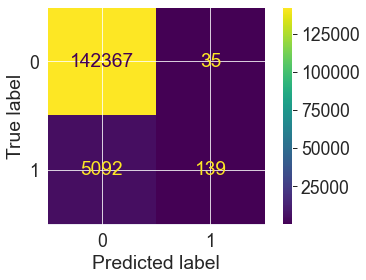

In [114]:
plot_confusion_matrix(logreg, X_te_fin_3, y_test)

# SMOTE'D LOGISTIC REGRESSION

In [115]:
sm = SMOTE(random_state=42)

X_tr_res, y_tr_res = sm.fit_resample(X_tr_fin_2, y_train)


In [116]:
y_tr_res.value_counts()

1    427464
0    427464
Name: isFraud, dtype: int64

In [117]:

logreg.fit(X_tr_res, y_tr_res)

log_y_pred_2 = logreg.predict(X_te_fin_3)

/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [118]:
print(logreg.score(X_te_fin_3, y_test))
print(confusion_matrix(y_test, log_y_pred_2))
print(classification_report(y_test,log_y_pred_2))

0.6283622225383214
[[89237 53165]
 [ 1701  3530]]
              precision    recall  f1-score   support

           0       0.98      0.63      0.76    142402
           1       0.06      0.67      0.11      5231

    accuracy                           0.63    147633
   macro avg       0.52      0.65      0.44    147633
weighted avg       0.95      0.63      0.74    147633



In [119]:
print(cross_val_score(logreg, X_tr_res, y_tr_res, cv=5))
print(np.mean(cross_val_score(logreg, X_tr_res, y_tr_res, cv=5)))

/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarni

[0.68140666 0.68944826 0.69024365 0.68929438 0.68862181]


/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/FRAUD/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarni

0.6878029521904618


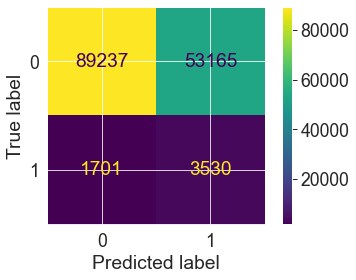

In [120]:
plot_confusion_matrix(logreg, X_te_fin_3, y_test)

# RANDOM FOREST

In [121]:
rfc = RandomForestClassifier(n_estimators=100, criterion='gini',
                               bootstrap = True,
                               max_features = 'sqrt', random_state=42)

rfc.fit(X_tr_res, y_tr_res)
rfc_y_pred = rfc.predict(X_te_fin_3)

print(rfc.score(X_te_fin_3, y_test))
print(confusion_matrix(y_test, rfc_y_pred))
print(classification_report(y_test, rfc_y_pred))

0.9709008148584666
[[141950    452]
 [  3844   1387]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    142402
           1       0.75      0.27      0.39      5231

    accuracy                           0.97    147633
   macro avg       0.86      0.63      0.69    147633
weighted avg       0.97      0.97      0.96    147633



In [122]:
print(cross_val_score(rfc, X_tr_res, y_tr_res, cv=3))
print(np.mean(cross_val_score(rfc, X_tr_res, y_tr_res, cv=3)))

[0.96128446 0.99718573 0.99710853]
0.9851929051335317


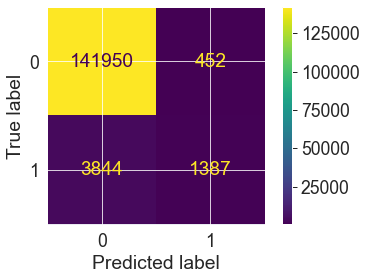

In [123]:
plot_confusion_matrix(rfc, X_te_fin_3, y_test)

# DECISION TREE

In [124]:
dt = DecisionTreeClassifier(class_weight='balanced')

dt.fit(X_tr_res, y_tr_res)

dt_y_pred = dt.predict(X_te_fin_3)

print(dt.score(X_te_fin_3, y_test))
print(confusion_matrix(y_test, dt_y_pred))
print(classification_report(y_test, dt_y_pred))

0.9568253710213841
[[138932   3470]
 [  2904   2327]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    142402
           1       0.40      0.44      0.42      5231

    accuracy                           0.96    147633
   macro avg       0.69      0.71      0.70    147633
weighted avg       0.96      0.96      0.96    147633



In [134]:
print(cross_val_score(dt, X_tr_res, y_tr_res, cv=3))
print(np.mean(cross_val_score(dt, X_tr_res, y_tr_res, cv=3)))

[0.95765608 0.98076329 0.98146861]
0.9732293245747009


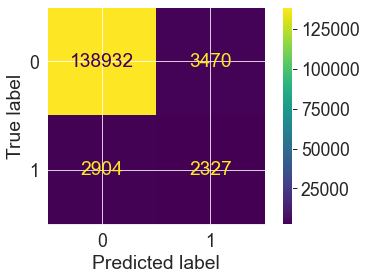

In [127]:
plot_confusion_matrix(dt, X_te_fin_3, y_test)

# NAIVE BAYES 

In [128]:
nb = GaussianNB()


nb.fit(X_tr_res, y_tr_res)

nb_y_pred = nb.predict(X_te_fin_3)

print(nb.score(X_te_fin_3, y_test))
print(confusion_matrix(y_test, nb_y_pred))
print(classification_report(y_test, nb_y_pred))

0.09051499326031442
[[  8417 133985]
 [   285   4946]]
              precision    recall  f1-score   support

           0       0.97      0.06      0.11    142402
           1       0.04      0.95      0.07      5231

    accuracy                           0.09    147633
   macro avg       0.50      0.50      0.09    147633
weighted avg       0.93      0.09      0.11    147633



In [129]:
print(cross_val_score(nb, X_tr_res, y_tr_res, cv=3))
print(np.mean(cross_val_score(nb, X_tr_res, y_tr_res, cv=3)))

[0.52293526 0.52302299 0.52237732]
0.5227785263788296


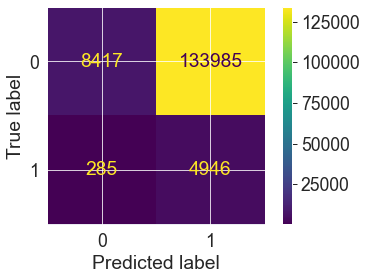

In [130]:
plot_confusion_matrix(nb, X_te_fin_3, y_test)

# STOCHASTIC GRADIENT DESCENT 

In [131]:
sgd = SGDClassifier()

sgd.fit(X_tr_res, y_tr_res)

sgd_y_pred = sgd.predict(X_te_fin_3)

print(sgd.score(X_te_fin_3, y_test))
print(confusion_matrix(y_test, sgd_y_pred))
print(classification_report(y_test, sgd_y_pred))

0.5597799949875706
[[78810 63592]
 [ 1399  3832]]
              precision    recall  f1-score   support

           0       0.98      0.55      0.71    142402
           1       0.06      0.73      0.11      5231

    accuracy                           0.56    147633
   macro avg       0.52      0.64      0.41    147633
weighted avg       0.95      0.56      0.69    147633



In [132]:
print(cross_val_score(sgd, X_tr_res, y_tr_res, cv=3))
print(np.mean(cross_val_score(sgd, X_tr_res, y_tr_res, cv=3)))

[0.69124067 0.68860887 0.69012127]
0.6900698070480789


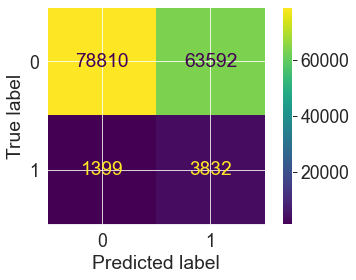

In [133]:
plot_confusion_matrix(sgd, X_te_fin_3, y_test)